<a href="https://colab.research.google.com/github/Bhavanadh/Ecommerce-sales-dashboard/blob/main/ecommerce_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

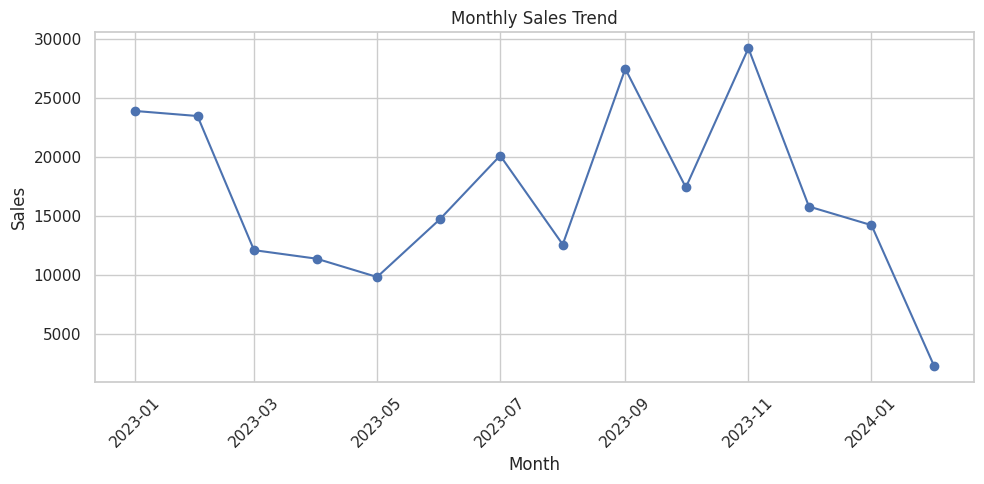

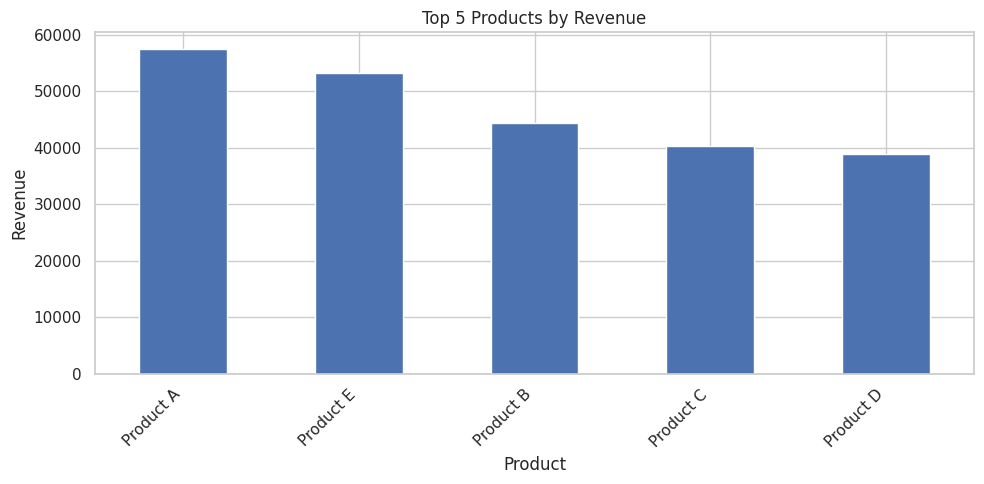

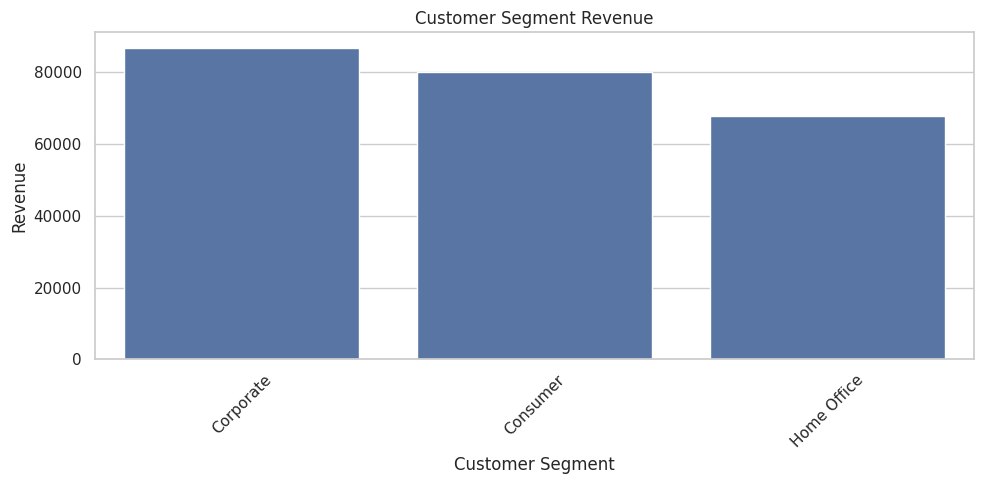

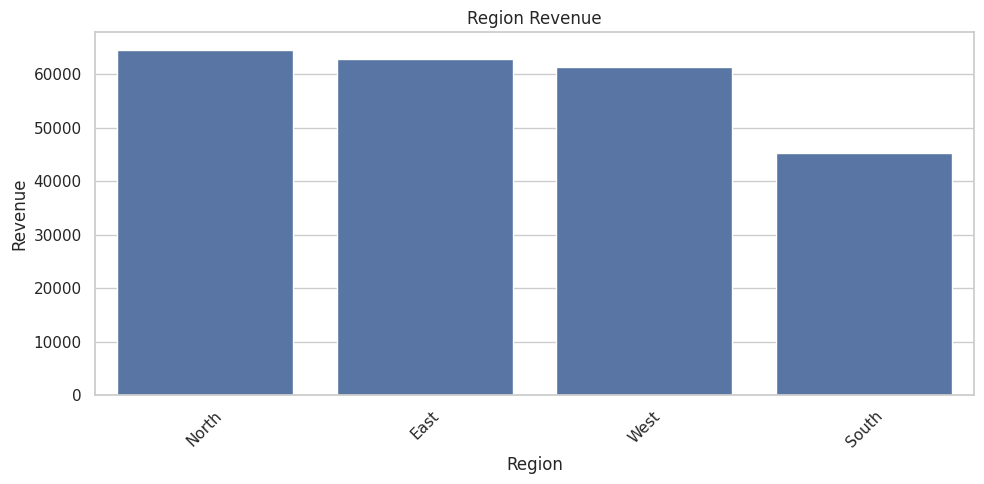

Seasonal decomposition failed: x must have 2 complete cycles requires 24 observations. x only has 14 observation(s)
SARIMAX forecast failed: too many indices for array: array is 0-dimensional, but 1 were indexed


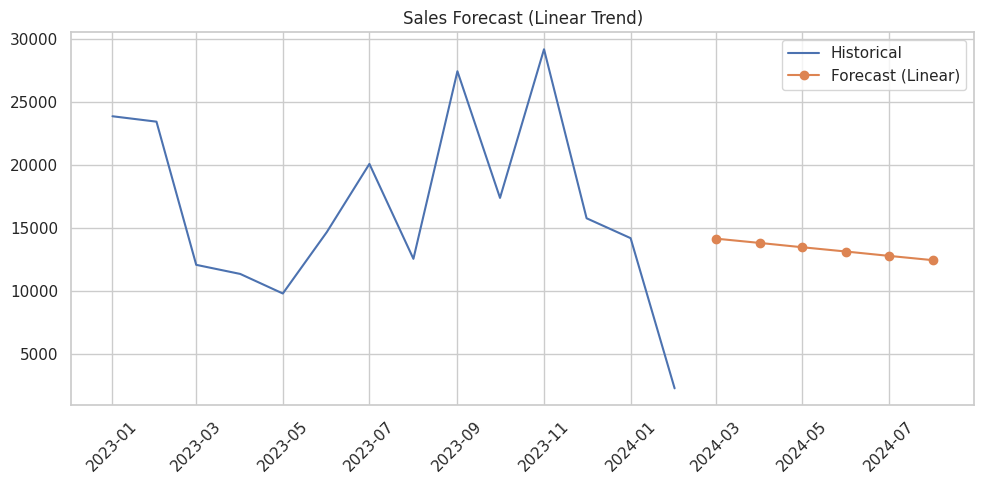


Outputs saved to /content/outputs


In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Install xlsxwriter if not present
try:
    import xlsxwriter
except ImportError:
    %pip install xlsxwriter
    import xlsxwriter

# statsmodels for ARIMA/SARIMAX forecasting
try:
    import statsmodels.api as sm
    from statsmodels.tsa.statespace.sarimax import SARIMAX
except Exception:
    sm = None

# pmdarima auto_arima (optional)
try:
    import pmdarima as pm
except Exception:
    pm = None

# Set plotting defaults
plt.rcParams.update({'figure.figsize': (10,5), 'figure.dpi': 100})
sns.set(style='whitegrid')
# Load dataset
DATA_PATH = 'ecommerce_sales_data.csv'
if not Path(DATA_PATH).exists():
    raise FileNotFoundError(f"{DATA_PATH} not found. Upload the dataset to the working folder and restart the notebook.")

df = pd.read_csv(DATA_PATH)

# Basic cleaning & preprocessing

# Expected columns: 'Order Date','Sales','Category','Sub-Category','Customer Segment','Region','Profit','Product'
# Normalize column names
df.columns = [c.strip() for c in df.columns]

# Parse date
if 'Order Date' in df.columns:
    df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
else:
    raise ValueError("Expected column 'Order Date' not found in dataset.")

# Drop rows without order date or sales
df = df.dropna(subset=['Order Date'])
if 'Sales' in df.columns:
    df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce').fillna(0.0)
else:
    raise ValueError("Expected column 'Sales' not found in dataset.")

# Optional profit
if 'Profit' in df.columns:
    df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce').fillna(0.0)

# Standardize product column if exists
if 'Product' not in df.columns and 'Product Name' in df.columns:
    df.rename(columns={'Product Name': 'Product'}, inplace=True)

# Fill missing categorical values
cat_cols = ['Category','Sub-Category','Customer Segment','Region','Product']
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].fillna('Unknown')

# Add derived columns
df['Order Month'] = df['Order Date'].dt.to_period('M').dt.to_timestamp()

# Aggregations & KPIs
# Monthly sales
monthly_sales = df.groupby('Order Month').agg(
    Sales=('Sales','sum'),
    Orders=('Order Date','count'),
    Profit=('Profit','sum') if 'Profit' in df.columns else ('Sales','sum')
).reset_index().sort_values('Order Month')

# Top products
if 'Product' in df.columns:
    top_products = df.groupby('Product').agg(Revenue=('Sales','sum'), Orders=('Order Date','count')).reset_index().sort_values('Revenue', ascending=False)
else:
    top_products = pd.DataFrame()

# Customer segmentation
if 'Customer Segment' in df.columns:
    segment_summary = df.groupby('Customer Segment').agg(Revenue=('Sales','sum'), Orders=('Order Date','count')).reset_index().sort_values('Revenue', ascending=False)
else:
    segment_summary = pd.DataFrame()

# Region summary
if 'Region' in df.columns:
    region_summary = df.groupby('Region').agg(Revenue=('Sales','sum'), Orders=('Order Date','count')).reset_index().sort_values('Revenue', ascending=False)
else:
    region_summary = pd.DataFrame()

# Visualizations (matplotlib/seaborn)
output_folder = Path('outputs')
output_folder.mkdir(exist_ok=True)

# Monthly Sales Trend
fig, ax = plt.subplots()
ax.plot(monthly_sales['Order Month'], monthly_sales['Sales'], marker='o')
ax.set_title('Monthly Sales Trend')
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_folder/'monthly_sales_trend.png')
plt.show()

# Top N products by revenue
N = 5
if not top_products.empty:
    fig, ax = plt.subplots()
    top_products.head(N).plot(kind='bar', x='Product', y='Revenue', legend=False, ax=ax)
    ax.set_title(f'Top {N} Products by Revenue')
    ax.set_ylabel('Revenue')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(output_folder/'top_products.png')
    plt.show()

# Customer segmentation
if not segment_summary.empty:
    fig, ax = plt.subplots()
    sns.barplot(data=segment_summary, x='Customer Segment', y='Revenue', ax=ax)
    ax.set_title('Customer Segment Revenue')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_folder/'customer_segment.png')
    plt.show()

# Region breakdown
if not region_summary.empty:
    fig, ax = plt.subplots()
    sns.barplot(data=region_summary, x='Region', y='Revenue', ax=ax)
    ax.set_title('Region Revenue')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_folder/'region_revenue.png')
    plt.show()

# Time-series forecasting (simple methods)
# Prepare monthly series
ts = monthly_sales.set_index('Order Month')['Sales'].asfreq('MS').fillna(0)

# Method A: Simple linear trend + seasonal decomposition forecasting
from statsmodels.tsa.seasonal import seasonal_decompose

try:
    decomposition = seasonal_decompose(ts, model='additive', period=12, extrapolate_trend='freq')
    decomposition.plot()
    plt.tight_layout()
    plt.savefig(output_folder/'decomposition.png')
    plt.show()
except Exception as e:
    print('Seasonal decomposition failed:', e)

# Forecast horizon (months)
horizon = 6

forecast_index = pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='MS')
forecast_series = None
# Method B: SARIMAX (if statsmodels available)
if sm is not None:
    try:
        # Simple SARIMAX with small seasonal order. For production tune parameters or use auto_arima.
        model = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        preds = model_fit.get_forecast(steps=horizon)
        forecast_series = preds.predicted_mean
        conf_int = preds.conf_int()

        # Plot
        fig, ax = plt.subplots()
        ax.plot(ts.index, ts.values, label='Historical')
        ax.plot(forecast_index, forecast_series.values, label='Forecast', marker='o')
        ax.fill_between(forecast_index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)
        ax.set_title('Sales Forecast (SARIMAX)')
        ax.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(output_folder/'sarimax_forecast.png')
        plt.show()
    except Exception as e:
        print('SARIMAX forecast failed:', e)

# Method C: Auto-ARIMA (pmdarima) -> only if pmdarima installed
if pm is not None and forecast_series is None:
    try:
        auto = pm.auto_arima(ts, seasonal=True, m=12, suppress_warnings=True)
        preds = auto.predict(n_periods=horizon)
        forecast_series = pd.Series(preds, index=forecast_index)
        # Plot
        fig, ax = plt.subplots()
        ax.plot(ts.index, ts.values, label='Historical')
        ax.plot(forecast_index, forecast_series.values, label='Forecast', marker='o')
        ax.set_title('Sales Forecast (Auto ARIMA)')
        ax.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(output_folder/'auto_arima_forecast.png')
        plt.show()
    except Exception as e:
        print('Auto ARIMA failed:', e)

# Fallback simple linear trend forecast if others failed
if forecast_series is None:
    # Use linear regression on time index
    from sklearn.linear_model import LinearRegression
    X = np.arange(len(ts)).reshape(-1,1)
    y = ts.values
    lr = LinearRegression()
    lr.fit(X, y)
    X_future = np.arange(len(ts), len(ts)+horizon).reshape(-1,1)
    preds = lr.predict(X_future)
    forecast_series = pd.Series(preds, index=forecast_index)

    fig, ax = plt.subplots()
    ax.plot(ts.index, ts.values, label='Historical')
    ax.plot(forecast_index, forecast_series.values, label='Forecast (Linear)', marker='o')
    ax.set_title('Sales Forecast (Linear Trend)')
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_folder/'linear_forecast.png')
    plt.show()

# Save forecast to CSV
forecast_out = pd.DataFrame({'Forecast': forecast_series}).reset_index().rename(columns={'index':'Order Month'})
forecast_out.to_csv(output_folder/'sales_forecast.csv', index=False)

# Inventory / Reorder estimation (basic)
# Compute average daily sales for each product (if product column exists)
if 'Product' in df.columns:
    daily = df.copy()
    daily['Order Date'] = pd.to_datetime(daily['Order Date'])
    # Select only the 'Sales' column for summing to avoid TypeError with non-numeric columns.
    daily = daily.set_index('Order Date')['Sales'].resample('D').sum().reset_index()

# Simple reorder point example for each product
inventory_estimates = None
if 'Product' in df.columns:
    product_daily = df.set_index('Order Date').groupby('Product').resample('D')['Sales'].sum().reset_index()
    product_stats = product_daily.groupby('Product')['Sales'].agg(['mean','std']).reset_index().rename(columns={'mean':'avg_daily_sales','std':'std_daily_sales'})
    product_stats['lead_time_days'] = 7  # example lead time
    z = 1.65  # service level ~95%
    product_stats['reorder_point'] = product_stats['avg_daily_sales'] * product_stats['lead_time_days'] + z * product_stats['std_daily_sales'] * np.sqrt(product_stats['lead_time_days'])
    inventory_estimates = product_stats
    product_stats.to_csv(output_folder/'inventory_estimates.csv', index=False)

# Export cleaned and aggregated tables for Power BI
monthly_sales.to_csv(output_folder/'monthly_sales.csv', index=False)
top_products.to_csv(output_folder/'top_products.csv', index=False)
segment_summary.to_csv(output_folder/'segment_summary.csv', index=False)
region_summary.to_csv(output_folder/'region_summary.csv', index=False)

# Optional: write a single Excel workbook with sheets
excel_path = output_folder/'ecommerce_report.xlsx'
with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
    df.to_excel(writer, sheet_name='raw_data', index=False)
    monthly_sales.to_excel(writer, sheet_name='monthly_sales', index=False)
    top_products.head(100).to_excel(writer, sheet_name='top_products', index=False)
    segment_summary.to_excel(writer, sheet_name='segments', index=False)
    region_summary.to_excel(writer, sheet_name='regions', index=False)
    if inventory_estimates is not None:
        inventory_estimates.to_excel(writer, sheet_name='inventory', index=False)

print('\nOutputs saved to', output_folder.resolve())


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
